# Clasificación con K-Nearest Neighbors (K-NN) - Mejorado

Este notebook aplica el algoritmo K-NN con diversas mejoras para intentar aumentar el rendimiento del modelo: selección de características, ponderación por distancia y evaluación de distintas métricas de distancia.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


sns.set(style='whitegrid')


## Carga de datos

In [2]:
# Cargar el dataset
df = pd.read_csv("../preprocessing/preprocessed.csv")  # Reemplazar con la ruta real si es necesario

# Mostrar información básica
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21741 entries, 0 to 21740
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   floor                         21741 non-null  float64
 1   sq_mt_built                   21741 non-null  float64
 2   sq_mt_useful                  21741 non-null  float64
 3   n_rooms                       21741 non-null  float64
 4   built_year                    21741 non-null  int64  
 5   has_terrace                   21741 non-null  int64  
 6   has_balcony                   21741 non-null  int64  
 7   is_renewal_needed             21741 non-null  int64  
 8   has_garden                    21741 non-null  int64  
 9   has_ac                        21741 non-null  float64
 10  has_pool                      21741 non-null  float64
 11  has_parking                   21741 non-null  int64  
 12  has_lift_no                   21741 non-null  int64  
 13  h

,floor,sq_mt_built,sq_mt_useful,n_rooms,built_year,has_terrace,has_balcony,is_renewal_needed,has_garden,has_ac,...,is_district__19,is_district__20,is_district__21,is_energy_certificate__A,is_energy_certificate__B,is_energy_certificate__C,is_energy_certificate__D,is_energy_certificate__E,is_energy_certificate__F,is_energy_certificate__G
0,3.0,-0.617536,-0.508454,-0.665855,1960,2,2,0,0,1.0,...,0,0,1,0,0,0,1,0,0,0
1,4.0,-0.572705,-0.166557,-0.003806,1965,1,2,1,0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,1.0,-0.393382,-0.616422,-0.665855,1963,2,2,0,0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0.0,-0.617536,-0.166557,-0.665855,1955,2,2,0,0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,4.0,-0.288777,0.031384,-0.665855,2003,2,2,0,0,1.0,...,0,0,1,0,0,0,0,1,0,0


## Preprocesamiento y selección de características

Puntuaciones de información mutua:
sq_mt_built             0.620388
price_per_m2            0.551243
n_rooms                 0.261435
sq_mt_useful            0.217885
has_lift_no             0.160193
built_year              0.123192
has_lift_yes            0.104207
house_type_Casa         0.093550
has_parking             0.089160
has_garden              0.079655
house_type_Piso         0.073215
has_pool                0.053912
has_lift_unknown        0.052461
is_district__13         0.052402
heating_type_central    0.048785
is_district__3          0.044645
is_exterior_2           0.044405
is_district__5          0.041282
floor                   0.040141
is_district__21         0.039136
dtype: float64


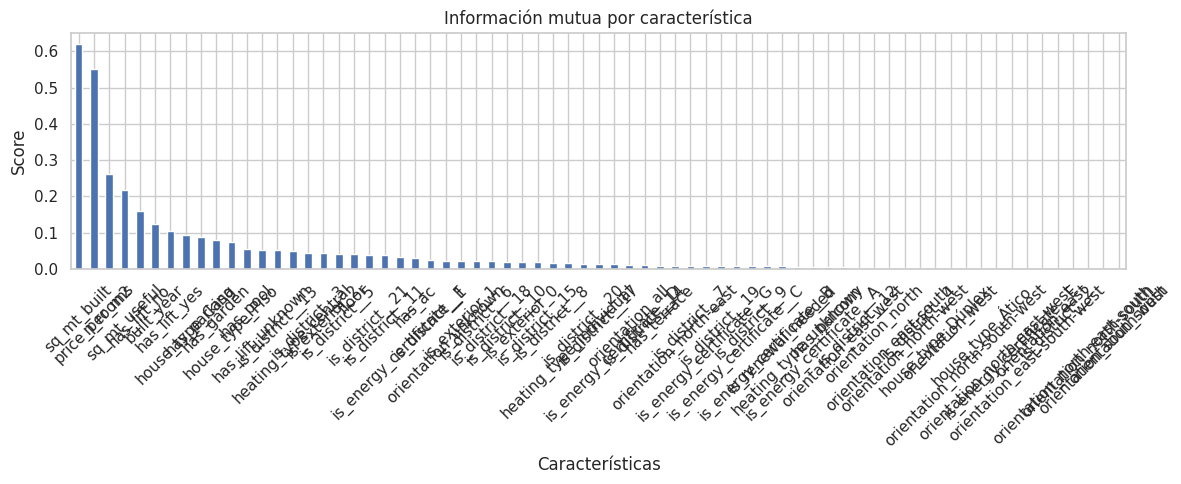

Columnas seleccionadas: ['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'built_year', 'has_garden', 'has_pool', 'has_parking', 'has_lift_no', 'has_lift_unknown', 'has_lift_yes', 'house_type_Casa', 'house_type_Piso', 'price_per_m2', 'is_district__13']


In [3]:
# Eliminar valores nulos
df = df.dropna()

# Separar variables
X = df.drop('price_category', axis=1)  # Reemplazar 'target' por la variable objetivo real
y = df['price_category']

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cálculo de la información mutua para cada característica
np.random.seed(42)  # Añadir semilla para reproducibilidad
mi_scores = mutual_info_classif(X_scaled, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Mostrar las puntuaciones ordenadas
print("Puntuaciones de información mutua:")
print(mi_series.head(20))

# Gráfico
plt.figure(figsize=(12,5))
mi_series.plot(kind='bar')
plt.title('Información mutua por característica')
plt.ylabel('Score')
plt.xlabel('Características')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Selección de características usando información mutua
np.random.seed(42)  # Mantener la misma semilla
selector = SelectKBest(score_func=mutual_info_classif, k=14)  # ajustar k si es necesario
X_selected = selector.fit_transform(X_scaled, y)

# Mostrar las columnas seleccionadas
selected_features = selector.get_support(indices=True)
selected_columns = X.columns[selected_features]
print("Columnas seleccionadas:", list(selected_columns))


## División del dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)


## Evaluación de distintas métricas y ponderaciones

In [5]:
# # Cálculo de la matriz de distancias para Gower
# X_train_df = pd.DataFrame(X_train, columns=selected_columns)
# X_test_df = pd.DataFrame(X_test, columns=selected_columns)
# gower_distances = gower.gower_matrix(X_test_df, X_train_df)

# def predict_knn_gower(gower_distances, y_train, k=5):
#     predictions = []
#     for i in range(gower_distances.shape[0]):
#         distances = gower_distances[i]
#         nearest_indices = np.argsort(distances)[:k]
#         nearest_labels = y_train.iloc[nearest_indices]
#         most_common = Counter(nearest_labels).most_common(1)[0][0]
#         predictions.append(most_common)
#     return predictions


# error_rates_gower = []
# k_range = range(1, 31)

# for k in k_range:
#     y_pred_gower = predict_knn_gower(gower_distances, y_train, k=k)
#     acc = accuracy_score(y_test, y_pred_gower)
#     error_rates_gower.append(1 - acc)

# # Visualización
# plt.figure(figsize=(10,6))
# plt.plot(k_range, error_rates_gower, marker='o', color='green')
# plt.title('Error de validación con distancia Gower')
# plt.xlabel('Número de vecinos: k')
# plt.ylabel('Error')
# plt.show()

Mejores parámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Mejor score de validación cruzada: 0.7674472292238752


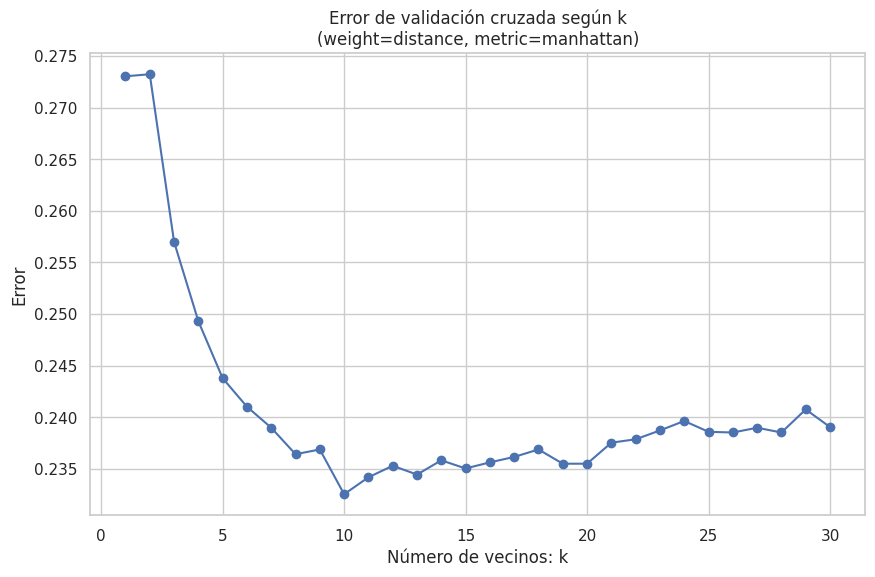

In [6]:
# Primero encontramos los mejores parámetros con GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 30)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid.best_params_)
print("Mejor score de validación cruzada:", grid.best_score_)

# Ahora evaluamos el error para diferentes k usando los mejores weight y metric
best_weight = grid.best_params_['weights']
best_metric = grid.best_params_['metric']

error_rates = []
k_range = range(1, 31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights=best_weight, metric=best_metric)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    error_rates.append(1 - scores.mean())

# Visualización del error
plt.figure(figsize=(10,6))
plt.plot(k_range, error_rates, marker='o')
plt.title(f'Error de validación cruzada según k\n(weight={best_weight}, metric={best_metric})')
plt.xlabel('Número de vecinos: k')
plt.ylabel('Error')
plt.show()


## Evaluación en el conjunto de prueba

In [7]:
# Evaluación con distancia Gower
# # Encontrar el mejor k basado en el menor error
# best_k = k_range[np.argmin(error_rates_gower)]
# print(f"Mejor k encontrado: {best_k}")

# # Evaluamos usando el mejor k con distancia Gower
# y_pred_gower = predict_knn_gower(gower_distances, y_train, k=best_k)

# print("Matriz de confusión:")
# plt.figure(figsize=(8, 6))
# cm = confusion_matrix(y_test, y_pred_gower)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Matriz de Confusión (Distancia Gower)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# print("\nInforme de clasificación:")
# report = classification_report(y_test, y_pred_gower, output_dict=True)
# metrics_df = pd.DataFrame(report).transpose()

# plt.figure(figsize=(10, 6))
# sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], 
#             annot=True, 
#             cmap='YlOrRd', 
#             fmt='.2f')
# plt.title('Métricas de Clasificación (Distancia Gower)')
# plt.show()

# print(classification_report(y_test, y_pred_gower))
# print(f"Accuracy: {accuracy_score(y_test, y_pred_gower):.4f}")



Matriz de confusión:


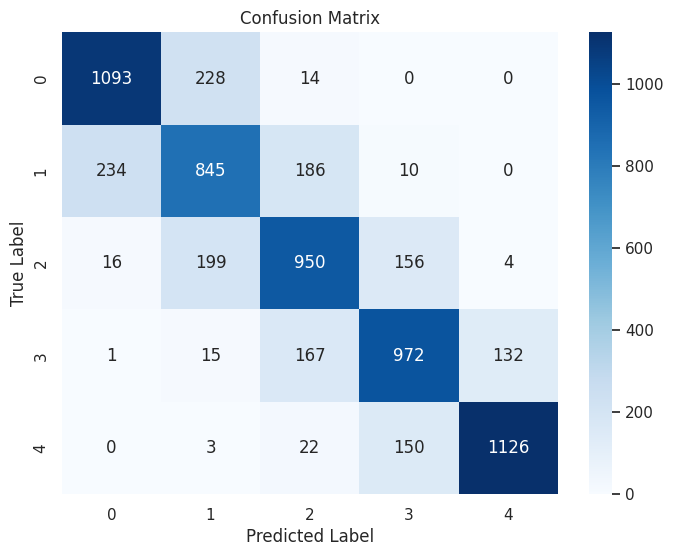


Informe de clasificación:


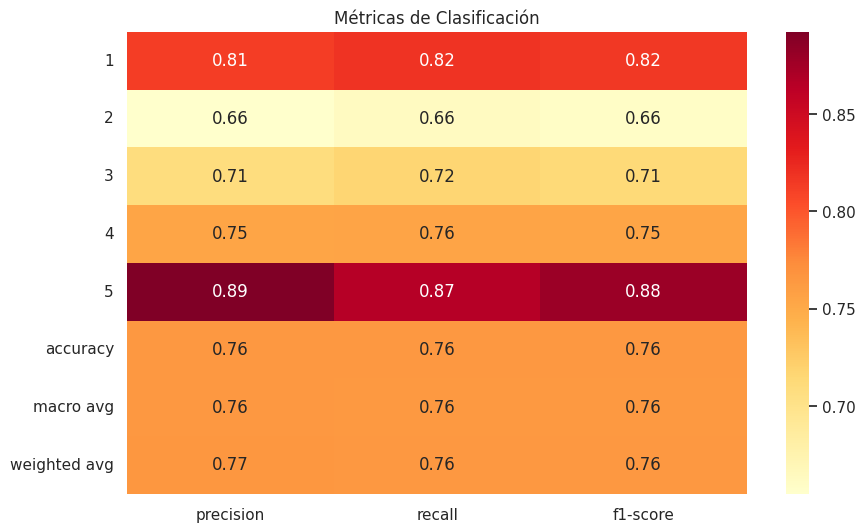

              precision    recall  f1-score   support

           1       0.81      0.82      0.82      1335
           2       0.66      0.66      0.66      1275
           3       0.71      0.72      0.71      1325
           4       0.75      0.76      0.75      1287
           5       0.89      0.87      0.88      1301

    accuracy                           0.76      6523
   macro avg       0.76      0.76      0.76      6523
weighted avg       0.77      0.76      0.76      6523

Accuracy: 0.7644


In [8]:
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Matriz de confusión:")
# print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("\nInforme de clasificación:")
report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f')
plt.title('Métricas de Clasificación')
plt.show()

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


## Conclusión

Este modelo mejora el K-NN estándar aplicando selección de características, ponderación por distancia y elección de métrica de distancia óptima. Se ha utilizado `GridSearchCV` para encontrar la mejor combinación de parámetros y se ha evaluado su desempeño sobre el conjunto de prueba.